In [ ]:
%pip install numpy pandas matplotlib statsmodels


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import Ridge
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

# Interactive widget
from ipywidgets import interact


# Retina mode
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [ ]:
# Download CO2 data from NOAA
url = 'https://gml.noaa.gov/webdata/ccgg/trends/co2/co2_mm_mlo.csv'

names = 'year,month,decimal date,average,deseasonalized,ndays,sdev,unc'.split(',')

# no index
df = pd.read_csv(url, skiprows=72, names=names, index_col=False)

In [ ]:
df.index = pd.to_datetime(df[['year', 'month']].apply(lambda x: '{}-{}'.format(x[0], x[1]), axis=1))

In [ ]:
# Create X and y

# X = months since first measurement

X = np.array(range(len(df)))
y = df.average.values

Text(0, 0.5, 'CO2 Level')

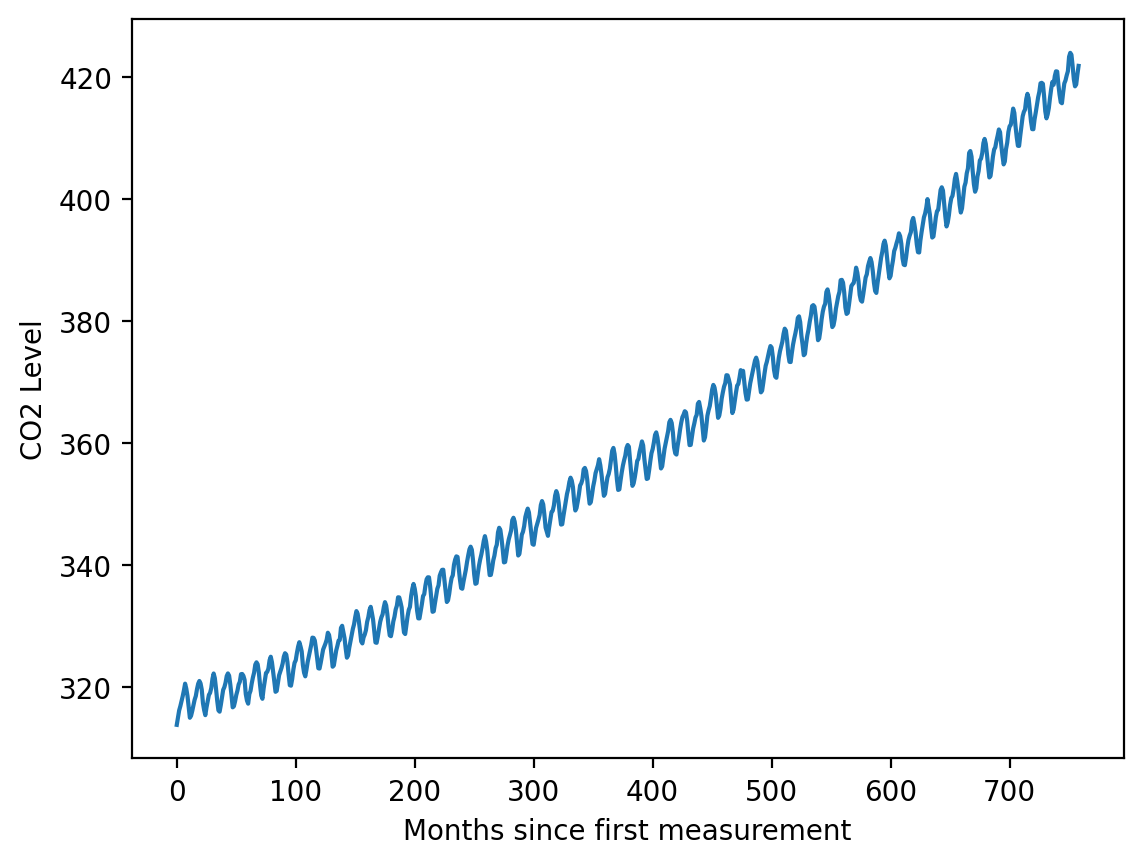

In [ ]:
plt.plot(X, y)
plt.xlabel('Months since first measurement')
plt.ylabel('CO2 Level')

<h2>Simple Linear Regression model

In [ ]:
# Spliting the data into train and test, 80:20 split
y = y.flatten().tolist()
split_index = int(0.8 * len(y))

train_data = y[:split_index]
X_train_data = X[:split_index]
test_data = y[split_index:]
X_test_data = X[split_index:]

In [ ]:
# Simple linear regression model that uses just the month value as the input
reg_slr = LinearRegression().fit(np.array(X_train_data).reshape(-1, 1), train_data)
y_hat_slr = reg_slr.predict(np.array(X_test_data).reshape(-1, 1))

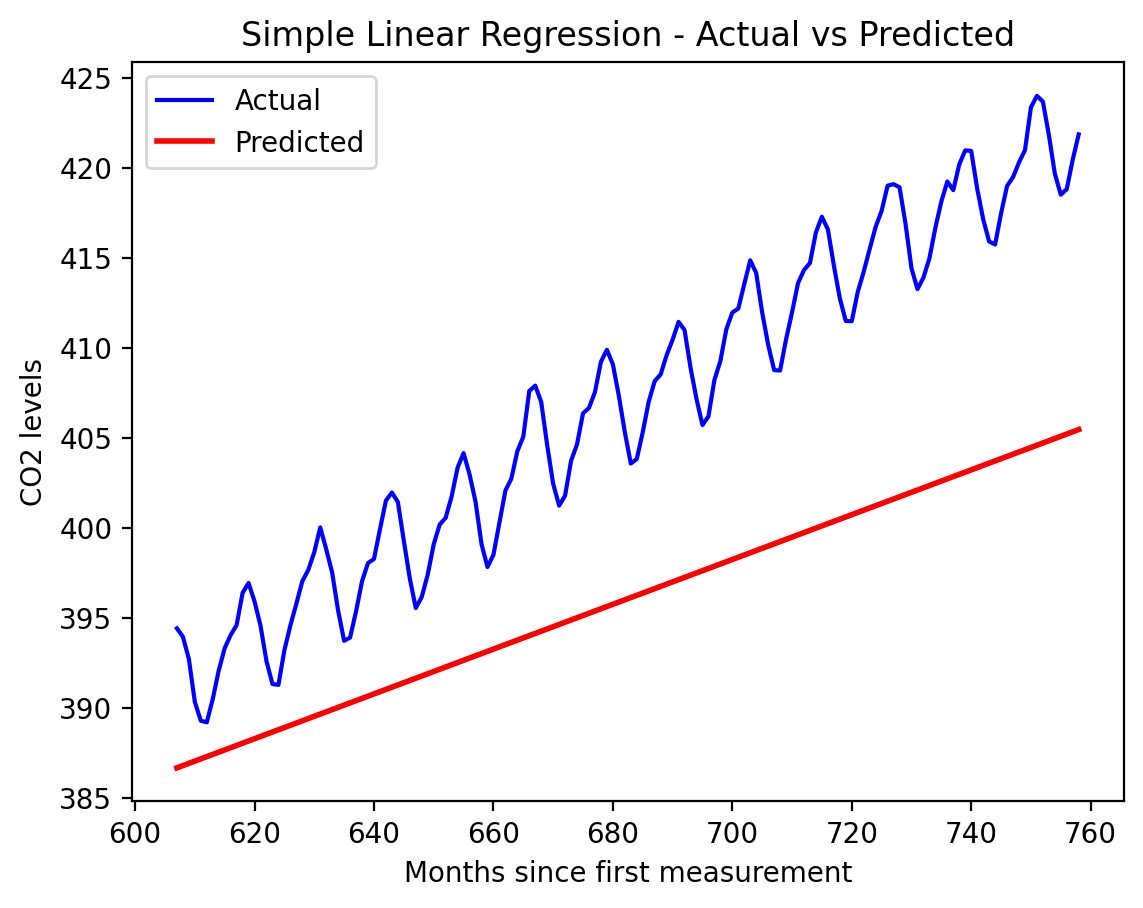

In [ ]:
# Plotting the actual values (y)
plt.plot(X_test_data, test_data, color='blue', label='Actual')

# Plotting the predicted values (y_hat)
plt.plot(X_test_data, y_hat_slr, color='red', linewidth=2, label='Predicted')

# Adding labels and title
plt.xlabel('Months since first measurement')
plt.ylabel('CO2 levels')
plt.title('Simple Linear Regression - Actual vs Predicted')
plt.legend()

# Display the plot
plt.show()

## Autocorrelation Function (ACF):

The Autocorrelation Function (ACF) measures the correlation between a time series and its lagged values. It quantifies how well the previous observations at different lags explain the current observation.
## Partial Autocorrelation Function (PACF):

The Partial Autocorrelation Function (PACF) measures the correlation between a time series and its lagged values, while controlling for the intermediate lags. It helps identify the direct relationship between two time points, excluding the influence of other time points in between.



In [ ]:
y_co = pd.Series(y)

<Figure size 1000x600 with 0 Axes>

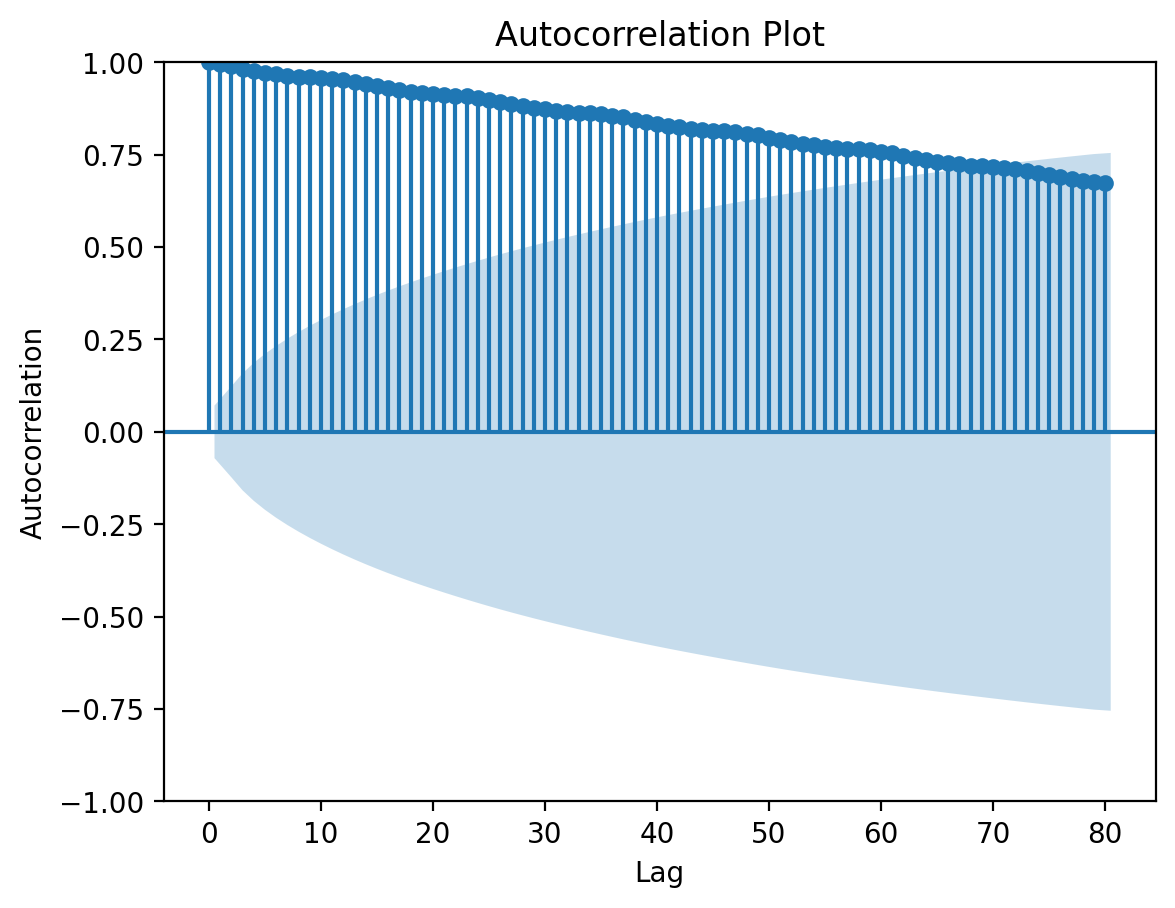

In [ ]:

# Plot the autocorrelation function (ACF) using statsmodels
plt.figure(figsize=(10, 6))
plot_acf(y_co, lags=80, title='Autocorrelation Plot')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.show()


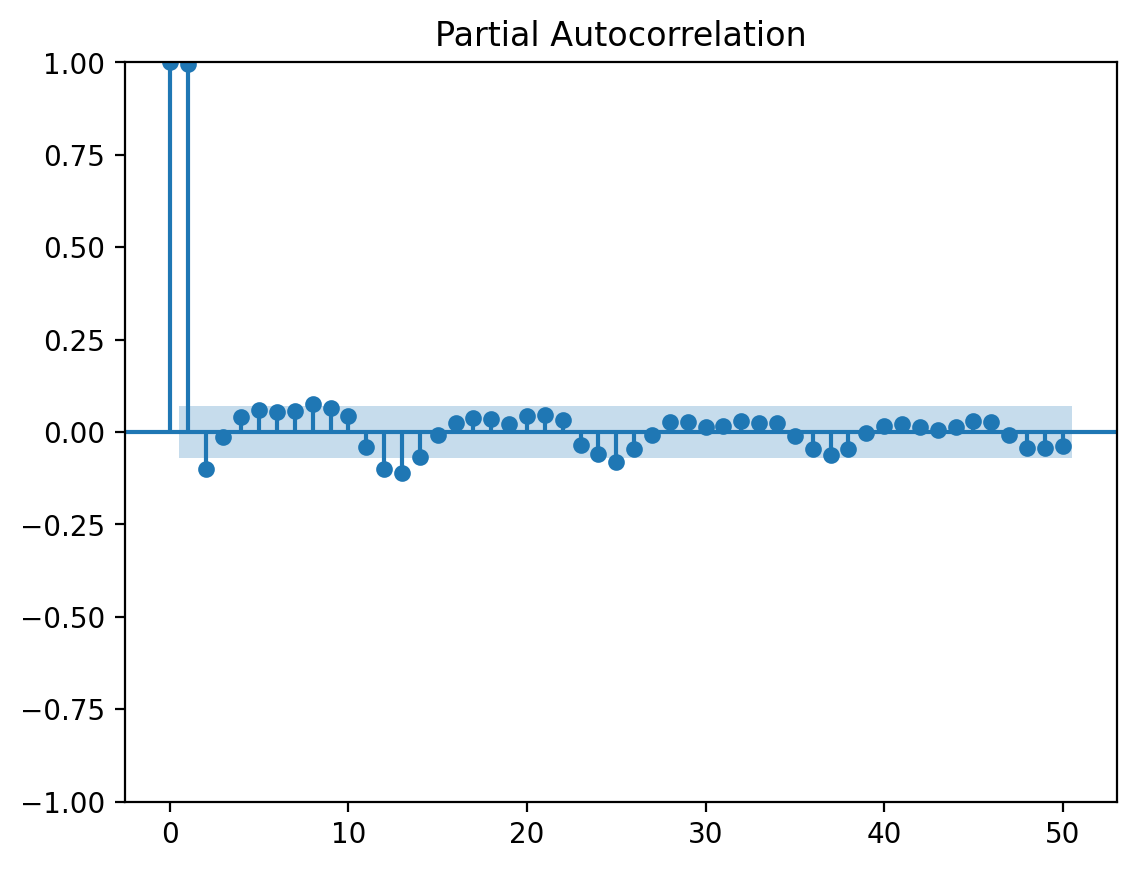

In [ ]:
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(y_co, lags=50)
plt.show()

<h2>Auto Regressive Model</h2>

We convert the CO2 level time sequence into an input feature matrix and the corresponding output vector by setting a <i>lag</i> value. A sliding window of <i>lag</i> length will be used across the sequence to create the feature matrix and the output.

In [ ]:
# making the features using previous values according to lag
def make_dataset(y, X, lag):
    X_train = []
    y_train = []
    months = []
    for i in range(len(y)-lag):
        row = y[i:i+lag]
        y_train.append(y[i+lag])
        X_train.append(row)

        month_value = X[i+lag]
        months.append(month_value)

    X_train = pd.DataFrame(X_train)
    y_train = pd.Series(y_train)
    return X_train, y_train, months

In [ ]:
# adding the month value as a feature
def make_dataset_with_month(y, X, lag):
    X_train = []
    y_train = []
    months_train = []

    for i in range(len(y)-lag):
        row = y[i:i+lag]
        y_train.append(y[i+lag])
        X_train.append(row)

        month_value = X[i+lag]
        months_train.append(month_value)

    X_train = pd.DataFrame(X_train)
    X_train[10] = months_train
    y_train = pd.Series(y_train)

    return X_train, y_train, months_train

In [ ]:
# example run of the model using a lag of 10
lag = 10
X_train, y_train, months_train = make_dataset(train_data, X_train_data, lag)
reg = LinearRegression().fit(X_train, y_train)
X_test, y_test, months_test = make_dataset(test_data,X_test_data, lag)
y_hat = reg.predict(X_test)
mse = mean_squared_error(y_test, y_hat)

print(f"Mean Squared Error (MSE): {mse}")

Mean Squared Error (MSE): 0.2099165801507042


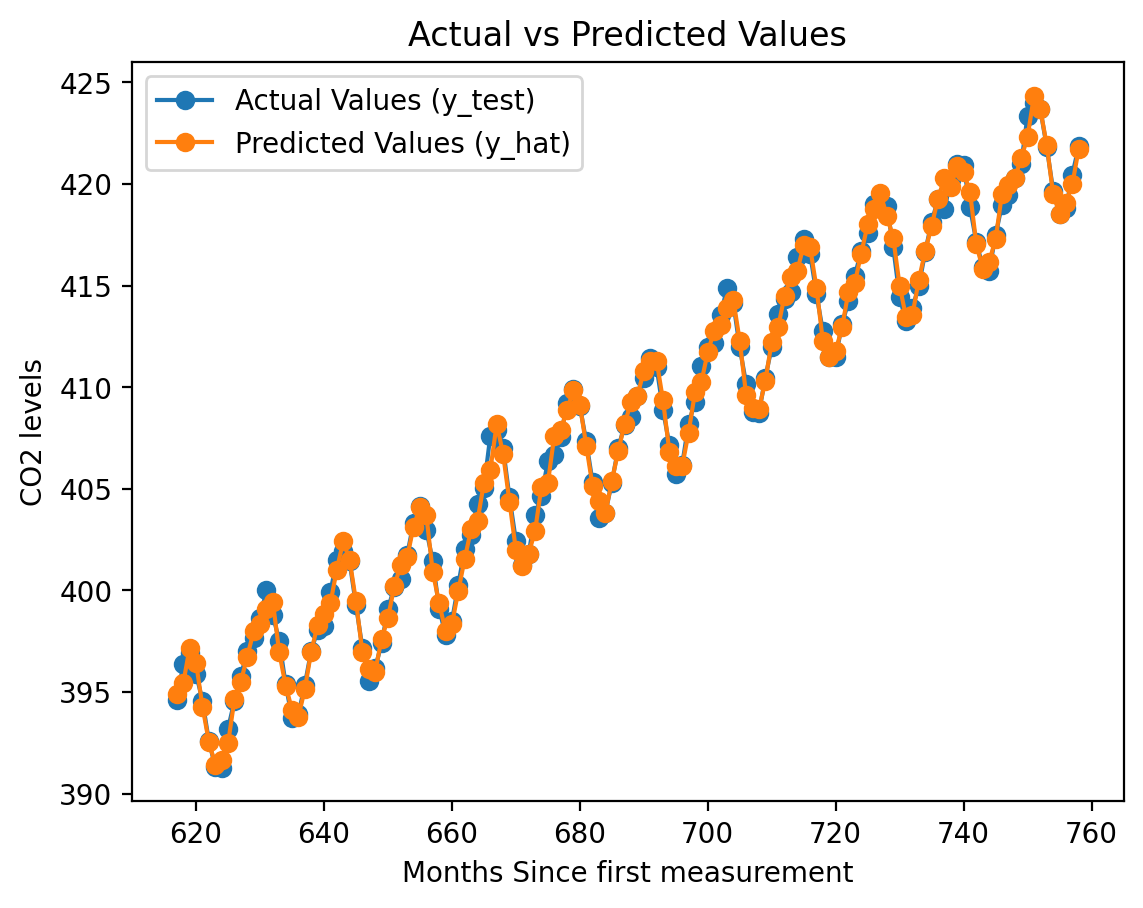

In [ ]:
# Ploting the predicted output for lag=10 for the test sequence
plt.plot(months_test, y_test, label='Actual Values (y_test)', marker='o')
plt.plot(months_test, y_hat, label='Predicted Values (y_hat)', marker='o')
plt.xlabel('Months Since first measurement')
plt.ylabel('CO2 levels')
plt.title('Actual vs Predicted Values')
plt.legend()
plt.show()

In [ ]:
# Creating a custom class for training and testing the AR model for different lag values
class AR_model:

  def __init__(self, lag, add_month = False):
    self.reg = LinearRegression()
    self.lag = lag
    self.add_month = add_month

  def train_AR_model(self, train_data, X_train_data):

    if(self.add_month):
      X_train, y_train, month_train = make_dataset_with_month(train_data, X_train_data, self.lag)
      self.reg.fit(X_train, y_train)

    else:
      X_train, y_train, months_train = make_dataset(train_data, X_train_data, self.lag)
      self.reg.fit(X_train, y_train)

    return self.reg

  def test_AR_model(self, test_data,X_test_data):
    if(self.add_month):
      X_test, y_test, month_test = make_dataset_with_month(test_data,X_test_data, self.lag)
      y_hat = self.reg.predict(X_test)
      mse = mean_squared_error(y_test, y_hat)


    else:
      X_test, y_test, months_test = make_dataset(test_data,X_test_data, self.lag)
      y_hat = self.reg.predict(X_test)
      mse = mean_squared_error(y_test, y_hat)

    return mse



In [ ]:
# Finding the variation in the mse values with increasing lag

lag_values = [1, 5, 10, 15, 20, 30, 35, 40, 50, 55, 65]

# Compairing the accuracy of the models with and without the month feature
loss_table_1 = []
loss_table_2 = []

for lag in lag_values:
    model_1 = AR_model(lag)
    model_2 = AR_model(lag, True)
    reg1 = model_1.train_AR_model(train_data, X_train_data)
    reg2 = model_2.train_AR_model(train_data, X_train_data)

    mse1 = model_1.test_AR_model(test_data,X_test_data)
    mse2 = model_2.test_AR_model(test_data,X_test_data)
    loss_table_1.append((lag, mse1))
    loss_table_2.append((lag, mse2))


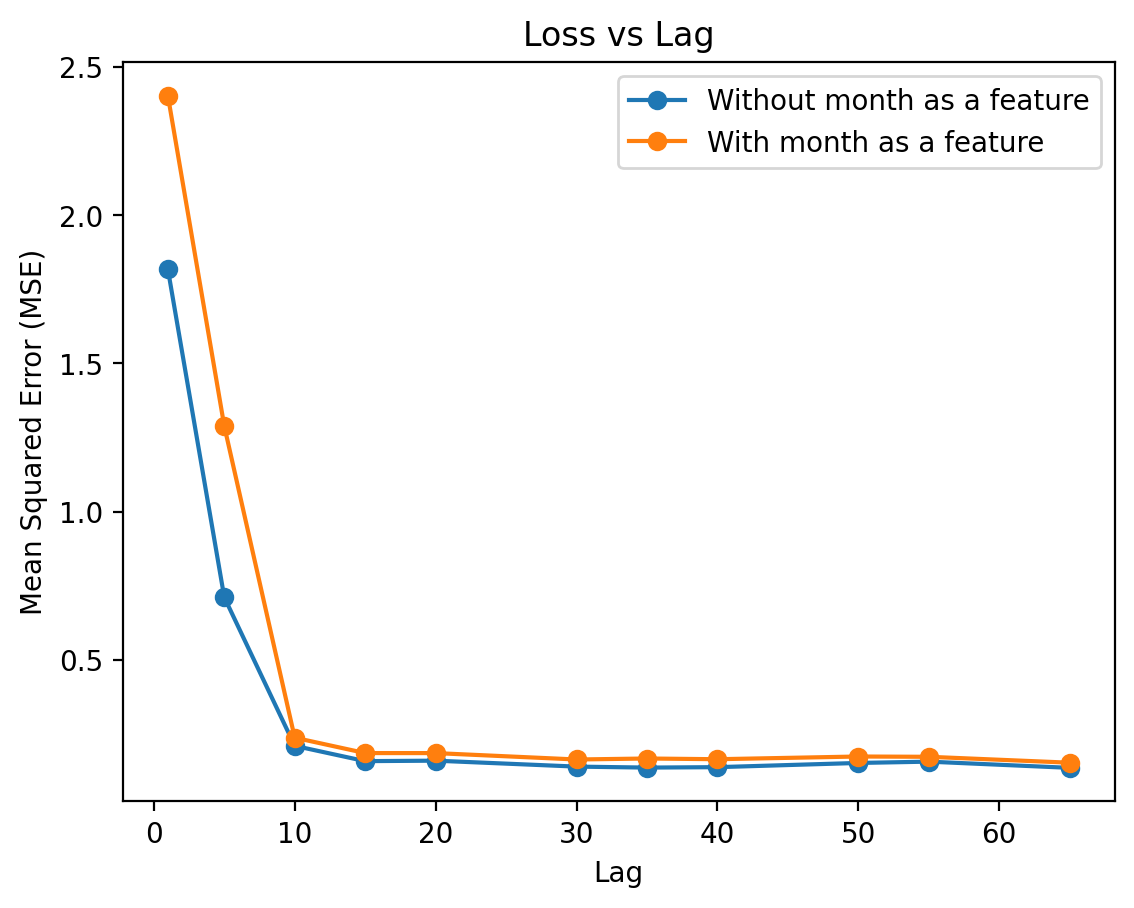

In [ ]:
# Visualize the loss values
lags, losses1 = zip(*loss_table_1)
lags, losses2 = zip(*loss_table_2)
plt.plot(lags, losses1,label='Without month as a feature', marker='o')
plt.plot(lags, losses2,label='With month as a feature', marker='o')
plt.xlabel('Lag')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('Loss vs Lag')
plt.legend()
plt.show()

<h3> Using a more complicated dataset : Air passengers dataset

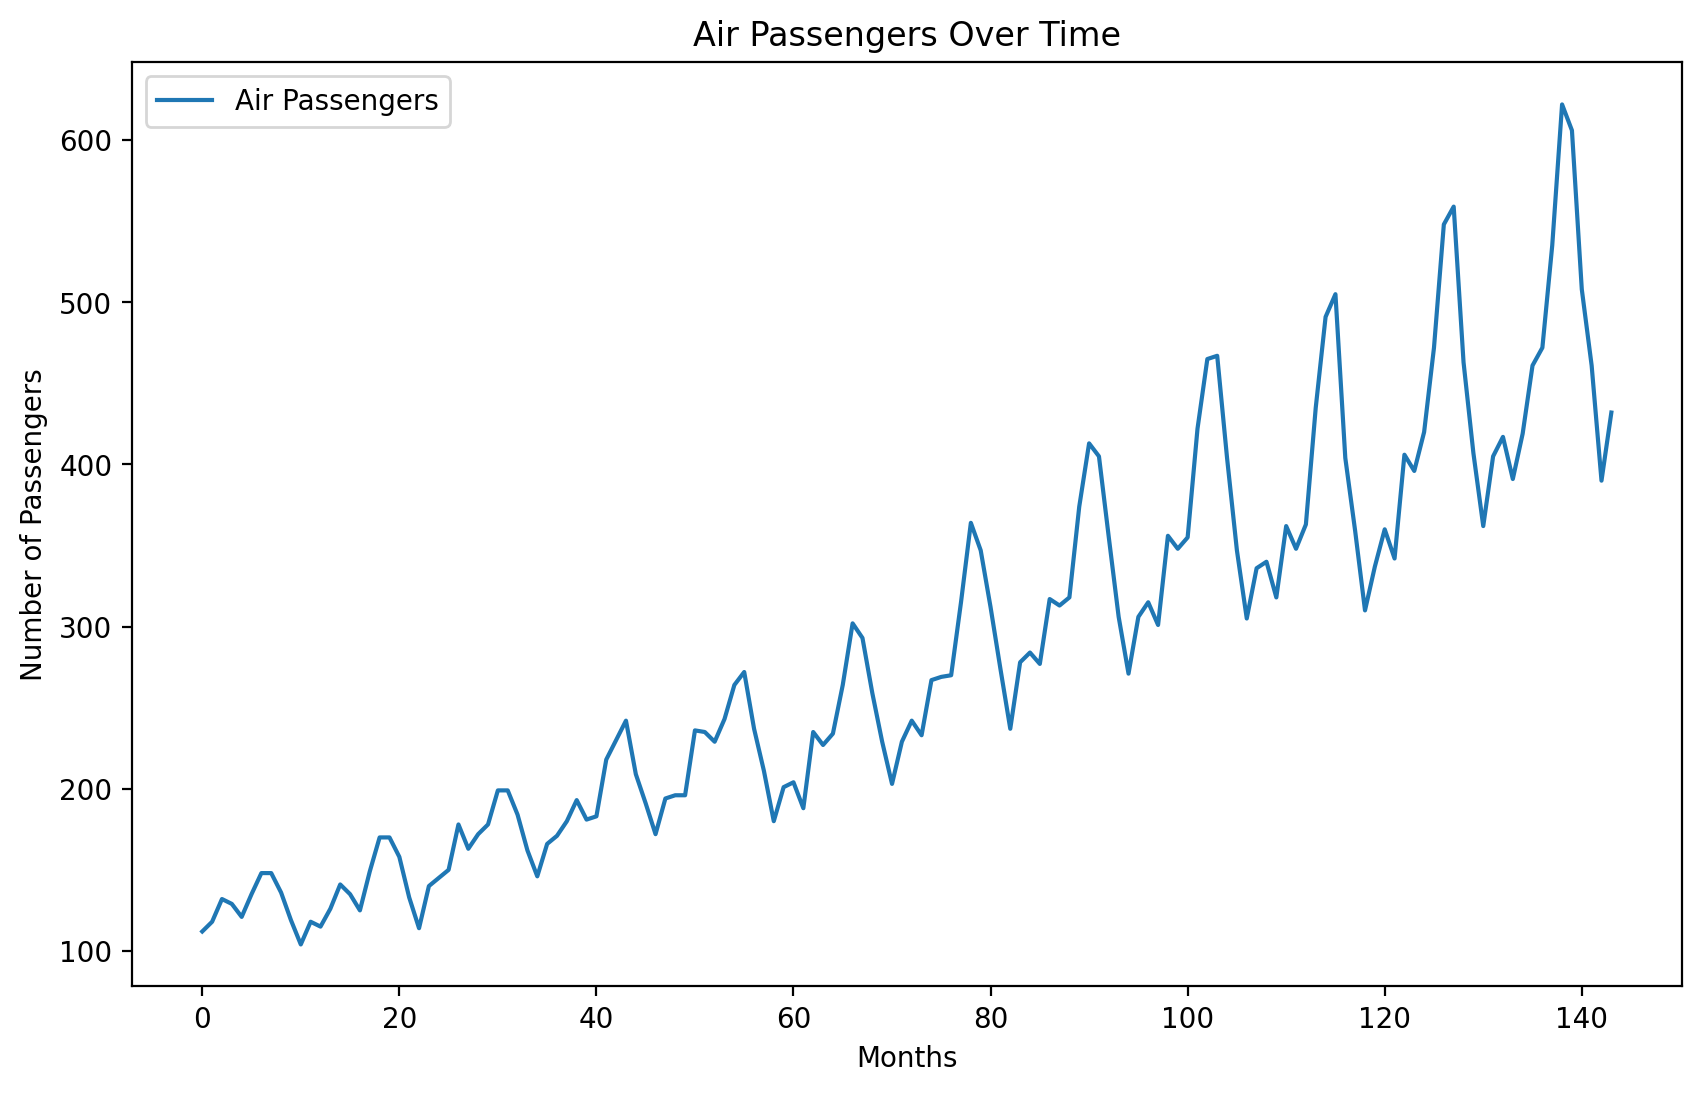

In [ ]:
# downloading and plotting the dataset
url_ap = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv'
df_ap = pd.read_csv(url_ap)
df_ap['Month'] = pd.to_datetime(df_ap['Month'])
df_ap.set_index('Month', inplace=True)
df = df_ap
plt.figure(figsize=(10, 6))
plt.plot(np.array(range(len(df_ap))), df_ap['Passengers'], label='Air Passengers')
plt.title('Air Passengers Over Time')
plt.xlabel('Months')
plt.ylabel('Number of Passengers')
plt.legend()
plt.show()

In [ ]:
# Extract features (X) and target variable (y)
X_ap = np.array(range(len(df_ap)))
y_ap= df_ap['Passengers'].values.flatten().tolist()

split_index_ap = int(0.8 * len(y_ap))
train_data_ap = y_ap[:split_index_ap]
X_train_data_ap = X_ap[:split_index_ap]
test_data_ap = y_ap[split_index_ap:]
X_test_data_ap = X_ap[split_index_ap:]

In [ ]:
y_co = pd.Series(y_ap)

<Figure size 1000x600 with 0 Axes>

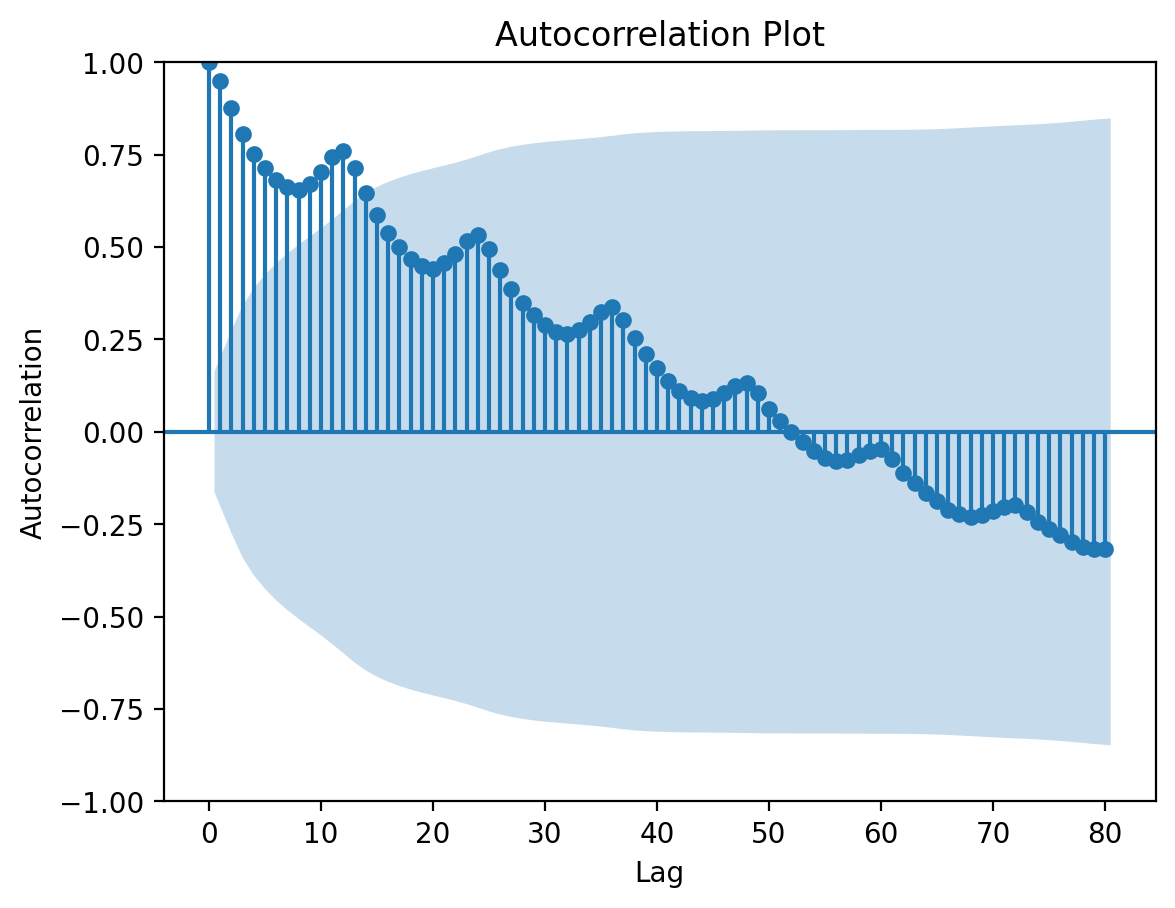

In [ ]:
# Plot the autocorrelation function (ACF) using statsmodels
plt.figure(figsize=(10, 6))
plot_acf(y_co, lags=80, title='Autocorrelation Plot')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.show()

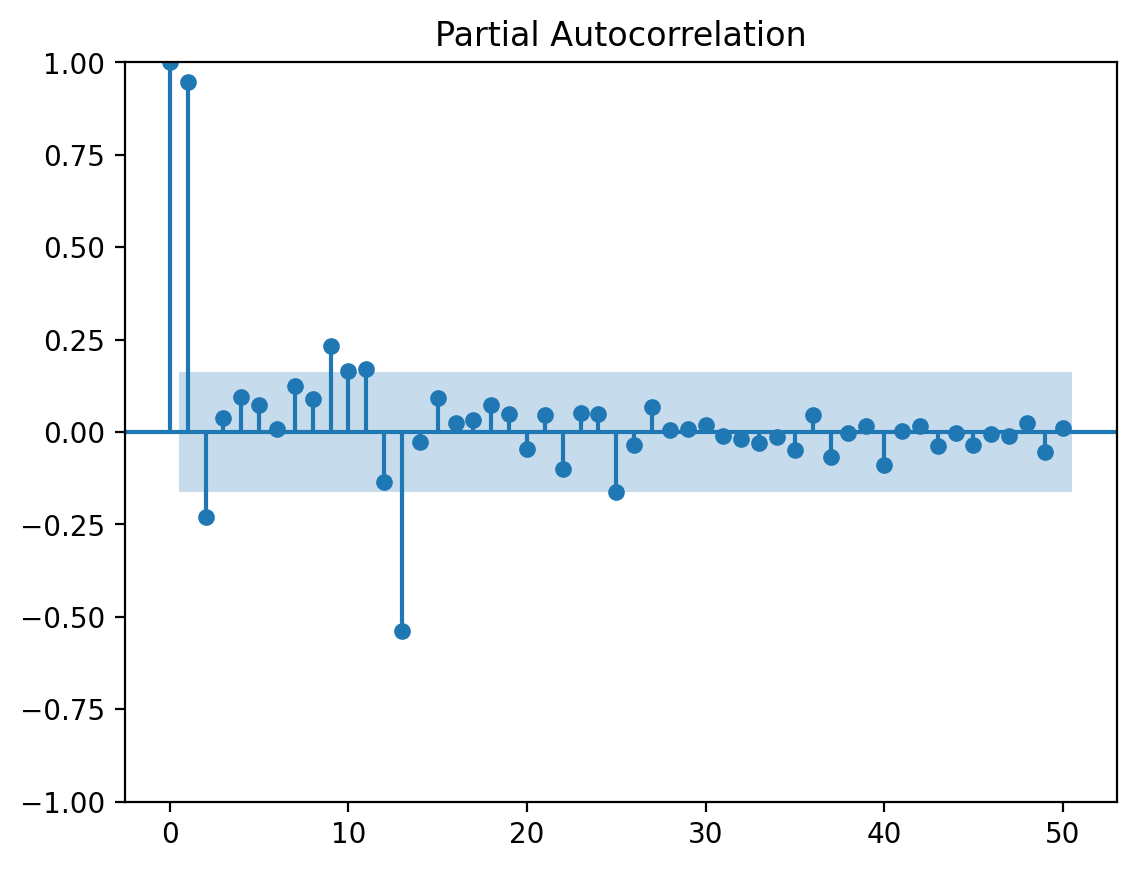

In [ ]:
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(y_co, lags=50)
plt.show()

In [ ]:
# example run of the model using a lag of 20
lag_ap = 20
X_train_ap, y_train_ap, months_train_ap = make_dataset(train_data_ap, X_train_data_ap, lag_ap)
reg_ap = LinearRegression().fit(X_train_ap, y_train_ap)
X_test_ap, y_test_ap, months_test_ap = make_dataset(test_data_ap,X_test_data_ap, lag_ap)
y_hat_ap = reg_ap.predict(X_test_ap)
rmse_ap = np.sqrt(mean_squared_error(y_test_ap, y_hat_ap))

print(f"Mean Squared Error (RMSE): {rmse_ap}")

Mean Squared Error (RMSE): 18.798515889301697


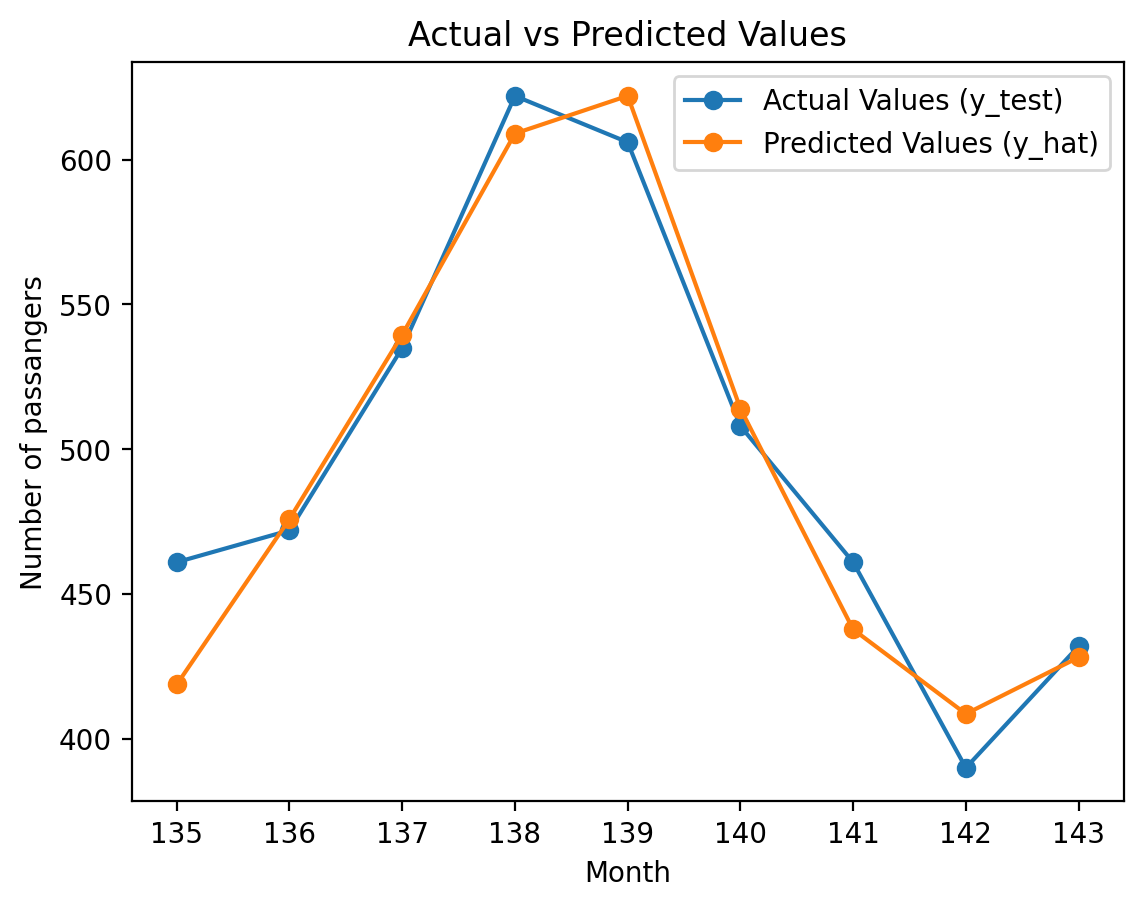

In [ ]:
# Ploting the predicted output for lag=10 for the test sequence
plt.plot(months_test_ap, y_test_ap, label='Actual Values (y_test)', marker='o')
plt.plot(months_test_ap, y_hat_ap, label='Predicted Values (y_hat)', marker='o')
plt.xlabel('Month')
plt.ylabel('Number of passangers')
plt.title('Actual vs Predicted Values')


plt.legend()
plt.show()

<h2> Comparison with another time series model : ConvLSTM

In [ ]:
# univariate convlstm example
from numpy import array
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import ConvLSTM2D


lag = 20
# split into samples
X, y,_ = make_dataset(train_data_ap, X_train_data_ap, lag)
# reshape from [samples, timesteps] into [samples, timesteps, rows, columns, features]
n_features = 1
n_seq = 4
n_steps = 5
X = array(X)
X = X.reshape((X.shape[0], n_seq, 1, n_steps, n_features))
# define model
model = Sequential()
model.add(ConvLSTM2D(filters=64, kernel_size=(1,2), activation='relu', input_shape=(n_seq, 1, n_steps, n_features)))
model.add(Flatten())
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
# fit model
model.fit(X, y, epochs=500, verbose=0)
# demonstrate prediction
X_test, y_test, months_test = make_dataset(test_data_ap, X_test_data_ap, lag)
X_test = array(X_test)
y_test = array(y_test)
X_test = X_test.reshape((X_test.shape[0], n_seq, 1, n_steps, n_features))
y_hat_lstm = model.predict(X_test)
y_hat_lstm = y_hat_lstm.flatten()

1/1 [==============================] - 1s 589ms/step


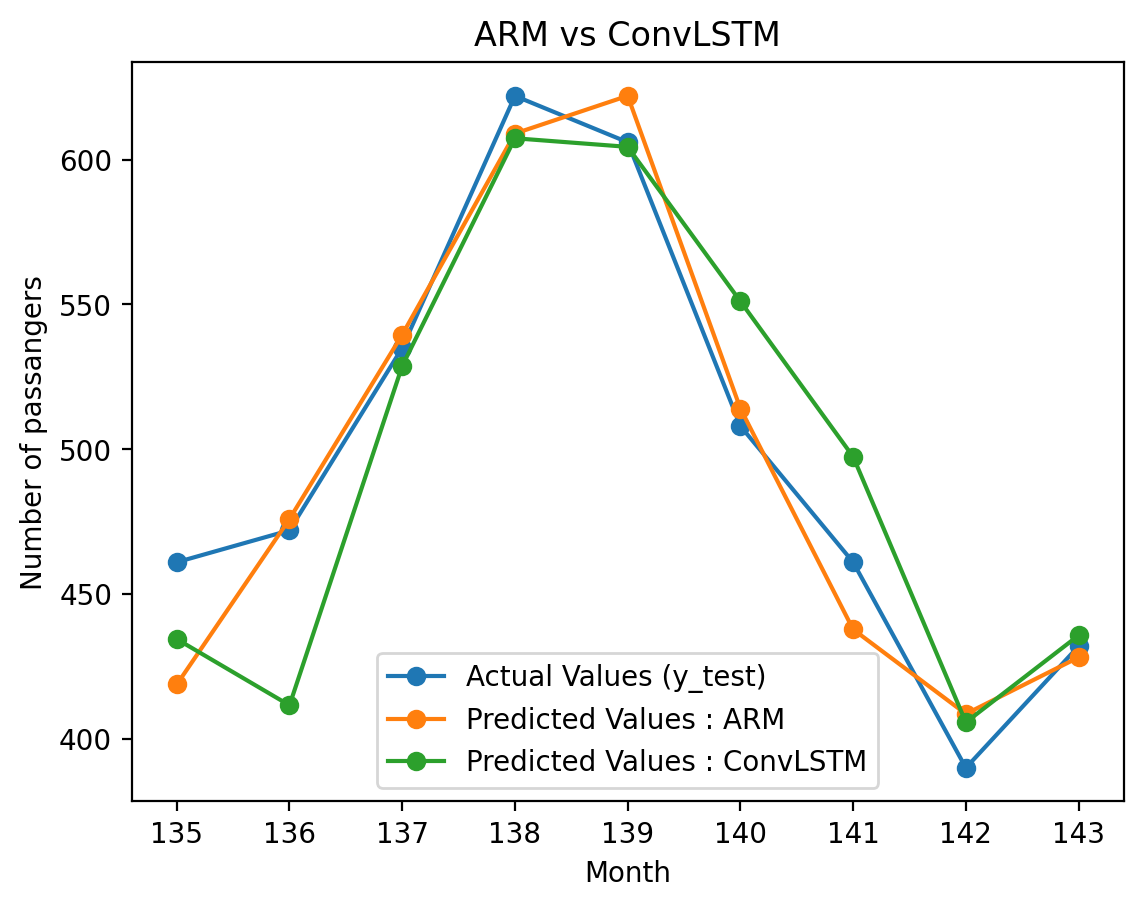

In [ ]:
# Ploting the predicted output for lag=10 for the test sequence
plt.plot(months_test_ap, y_test_ap, label='Actual Values (y_test)', marker='o')
plt.plot(months_test_ap, y_hat_ap, label='Predicted Values : ARM', marker='o')
plt.plot(months_test_ap, y_hat_lstm, label='Predicted Values : ConvLSTM', marker='o')
plt.xlabel('Month')
plt.ylabel('Number of passangers')
plt.title('ARM vs ConvLSTM')


plt.legend()
plt.show()

In [ ]:
# Creating a class to train and test the ConvLSTM model

class custom_ConvLSTM:

  def __init__(self, lag,n_seq, n_steps, n_features=1):
    self.lag = lag
    self.n_features = n_features
    self.n_steps = n_steps
    self.n_seq = n_seq
    self.model = Sequential()
    self.model.add(ConvLSTM2D(filters=64, kernel_size=(1,2), activation='relu', input_shape=(n_seq, 1, n_steps, n_features)))
    self.model.add(Flatten())
    self.model.add(Dense(1))
    self.model.compile(optimizer='adam', loss='mse')

  def train(self, train_data, X_train_data):
    X_train, y_train, months_train = make_dataset(train_data, X_train_data, self.lag)
    X_train = array(X_train)
    y_train = array(y_train)
    X_train = X_train.reshape((X_train.shape[0], self.n_seq, 1, self.n_steps, self.n_features))
    self.model.fit(X_train, y_train, epochs=500, verbose=0)

  def test(self, test_data, X_test_data):
    X_test, y_test, months_test = make_dataset(test_data, X_test_data, self.lag)
    X_test = array(X_test)
    y_test = array(y_test)
    X_test = X_test.reshape((X_test.shape[0], self.n_seq, 1, self.n_steps, self.n_features))
    y_hat_lstm = self.model.predict(X_test)
    y_hat_lstm = y_hat_lstm.flatten()

    mse_lstm = mean_squared_error(y_test, y_hat_lstm)
    return mse_lstm



In [ ]:
import random

def random_split(original_number):
    # Find factors of the original number
    factors = [i for i in range(2, original_number) if original_number % i == 0]

    # Select one factor randomly
    factor = random.choice(factors)

    # Calculate the other factor
    other_factor = original_number // factor

    return factor, other_factor